# Illustrative example

This example explains the usage of the library package `objective_weighting` that provides methods for multi-criteria decision analysis using objective weighting methods. This library contains module `weighting_methods` with the following weighting methods:

1. Equal `equal_weighting`

2. Entropy `entropy_weighting`

3. Standard deviation `std_weighting`

4. CRITIC `critic_weighting`

5. Gini coefficient-based `gini_weighting`

6. MEREC `merec_weighting`

7. Statistical variance `stat_var_weighting`

8. CILOS `cilos_weighting`

9. IDOCRIW `idocriw_weighting`

10. Angle `angle_weighting`

11. Coefficient of variance `coeff_var_weighting`

In addition to the weighting methods, the library also provides other methods necessary for multi-criteria decision analysis, which are as follows:

The VIKOR method for multi-criteria decision analysis `VIKOR` in module `mcda_methods`,

Normalization techniques:

1. Linear `linear_normalization`

2. Minimum-Maximum `minmax_normalization`

3. Maximum `max_normalization`

4. Sum `sum_normalization`

5. Vector `vector_normalization`

Correlation coefficients:

1. Spearman rank correlation coefficient rs `spearman`

2. Weighted Spearman rank correlation coefficient rw `weighted_spearman`

3. Pearson coefficent `pearson_coeff`

Import other necessary Python modules.

In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

Import the necessary modules and methods from package `objective_weighting`.

In [2]:
from objective_weighting.mcda_methods import VIKOR
from objective_weighting.mcda_methods import VIKOR_SMAA
from objective_weighting.additions import rank_preferences
from objective_weighting import correlations as corrs
from objective_weighting import normalizations as norm_methods
from objective_weighting import weighting_methods as mcda_weights

Functions for results visualization.

In [3]:
# Functions for visualizations

def plot_barplot(df_plot, x_name, y_name, title):
    """
    Display stacked column chart of weights for criteria for `x_name == Weighting methods`
    and column chart of ranks for alternatives `x_name == Alternatives`

    Parameters
    ----------
        df_plot : dataframe
            dataframe with criteria weights calculated different weighting methods
            or with alternaives rankings for different weighting methods
        x_name : str
            name of x axis, Alternatives or Weighting methods
        y_name : str
            name of y axis, Ranks or Weight values
        title : str
            name of chart title, Weighting methods or Criteria

    Examples
    ----------
    >>> plot_barplot(df_plot, x_name, y_name, title)
    """
    
    list_rank = np.arange(1, len(df_plot) + 1, 1)
    stacked = True
    width = 0.5
    if x_name == 'Alternatives':
        stacked = False
        width = 0.8
    elif x_name == 'Alternative':
        pass
    else:
        df_plot = df_plot.T
    ax = df_plot.plot(kind='bar', width = width, stacked=stacked, edgecolor = 'black', figsize = (9,4))
    ax.set_xlabel(x_name, fontsize = 12)
    ax.set_ylabel(y_name, fontsize = 12)

    if x_name == 'Alternatives':
        ax.set_yticks(list_rank)

    ax.set_xticklabels(df_plot.index, rotation = 'horizontal')
    ax.tick_params(axis = 'both', labelsize = 12)

    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
    ncol=4, mode="expand", borderaxespad=0., edgecolor = 'black', title = title, fontsize = 11)

    ax.grid(True, linestyle = '--')
    ax.set_axisbelow(True)
    plt.tight_layout()
    plt.savefig('results/bar_chart_weights_' + x_name + '.pdf')
    plt.savefig('results/bar_chart_weights_' + x_name + '.eps')
    plt.show()


def draw_heatmap(data, title):
    """
    Display heatmap with correlations of compared rankings generated using different methods

    Parameters
    ----------
        data : dataframe
            dataframe with correlation values between compared rankings
        title : str
            title of chart containing name of used correlation coefficient

    Examples
    ----------
    >>> draw_heatmap(data, title)
    """

    plt.figure(figsize = (6, 4))
    sns.set(font_scale=1.0)
    heatmap = sns.heatmap(data, annot=True, fmt=".2f", cmap="RdYlBu",
                          linewidth=0.5, linecolor='w')
    plt.yticks(va="center")
    plt.xlabel('Weighting methods')
    plt.title('Correlation coefficient: ' + title)
    plt.tight_layout()
    plt.savefig('results/heatmap_weights.pdf')
    plt.savefig('results/heatmap_weights.eps')
    plt.show()

    
def draw_heatmap_smaa(data, title):
    """
    Display heatmap with correlations of compared rankings generated using different methods

    Parameters
    ----------
        data : dataframe
            dataframe with correlation values between compared rankings
        title : str
            title of chart containing name of used correlation coefficient

    Examples
    ----------
    >>> draw_heatmap(data, title)
    """

    sns.set(font_scale=1.0)
    heatmap = sns.heatmap(data, annot=True, fmt=".2f", cmap="RdYlBu_r",
                        linewidth=0.05, linecolor='w')
    plt.yticks(rotation=0)
    plt.ylabel('Alternatives')
    plt.tick_params(labelbottom=False,labeltop=True)
    
    plt.title(title)
    plt.tight_layout()
    plt.savefig('results/heatmap_smaa.pdf')
    plt.savefig('results/heatmap_smaa.eps')
    plt.show()


def plot_boxplot(data):
    """
    Display boxplot showing distribution of criteria weights determined with different methods.

    Parameters
    ----------
        data : dataframe
            dataframe with correlation values between compared rankings

    Examples
    ---------
    >>> plot_boxplot(data)
    """
    
    df_melted = pd.melt(data)
    plt.figure(figsize = (7, 4))
    ax = sns.boxplot(x = 'variable', y = 'value', data = df_melted, width = 0.6)
    ax.grid(True, linestyle = '--')
    ax.set_axisbelow(True)
    ax.set_xlabel('Criterion', fontsize = 12)
    ax.set_ylabel('Different weights distribution', fontsize = 12)
    plt.tight_layout()
    plt.savefig('results/boxplot_weights.pdf')
    plt.savefig('results/boxplot_weights.eps')
    plt.show()


# Create dictionary class
class Create_dictionary(dict):
  
    # __init__ function
    def __init__(self):
        self = dict()
          
    # Function to add key:value
    def add(self, key, value):
        self[key] = value

As an illustrative example, a dataset will be used containing performances of the twelve best-selling electric cars in 2021 according to a ranking available at https://www.caranddriver.com/features/g36278968/best-selling-evs-of-2021/ The dataset is displayed below. $A_1$-$A_{12}$ are the individual alternatives in rows, columns $C_1$-$C_{11}$ denote the criteria, and the Type row contains the criteria type, where 1 indicates a profit criterion (stimulant) and -1 a cost criterion (destimulant). The following are the evaluation criteria for the electric cars evaluated in this research.

In [4]:
criteria_presentation = pd.read_csv('criteria_electric_cars.csv', index_col = 'Cj')
criteria_presentation

,Name,Unit,Type
Cj,,,
C1,Max speed,mph,1
C2,Battery capacity,kWh,1
C3,Electric motor,kW,1
C4,Maximum torque,Nm,1
C5,Horsepower,hp,1
C6,EPA Fuel Economy Combined,MPGe,1
C7,EPA Fuel Economy City,MPGe,1
C8,EPA Fuel Economy Highway,MPGe,1
C9,EPA range,miles,1


In [5]:
data_presentation = pd.read_csv('electric_cars_2021.csv', index_col = 'Ai')
data_presentation

,Name,C1 Max speed [mph],C2 Battery [kWh],C3 Electric motor [kW] Front,C4 Torque [Nm] Front,C5 Mechanical horsepower [hp],C6 EPA Fuel Economy Combined [MPGe],C7 EPA Fuel Economy City [MPGe],C8 EPA Fuel Economy Highway [MPGe],C9 EPA range [miles],"C10 Turning Diameter / Radius, curb to curb [feet]",C11 Base price [$]
Ai,,,,,,,,,,,,
A1,Tesla Model Y,155.3,74.0,340,673,456.0,111,115,106,244,39.8,65440
A2,Tesla Model 3,162.2,79.5,247,639,283.0,113,118,107,263,38.8,60440
A3,Ford Mustang Mach-E,112.5,68.0,198,430,266.0,98,105,91,230,38.1,56575
A4,Chevrolet Bolt EV and EUV,90.1,66.0,150,360,201.2,120,131,109,259,34.8,32495
A5,Volkswagen ID.4,99.4,77.0,150,310,201.2,97,102,90,260,36.4,45635
A6,Nissan Leaf,89.5,40.0,110,320,147.5,111,123,99,226,34.8,28425
A7,Audi e-tron and e-tron Sportback,124.3,95.0,125,247,187.7,78,78,77,222,40.0,84595
A8,Porsche Taycan,155.3,79.2,160,300,214.6,79,79,80,227,38.4,105150
A9,Tesla Model S,162.2,100.0,205,420,502.9,120,124,115,402,40.3,96440


Load a decision matrix containing only the performance values of the alternatives against the criteria and the criteria type in the last row, as shown below. Transform the decision matrix and criteria type from dataframe to NumPy array.

In [6]:
# Load data from CSV
filename = 'dataset_cars.csv'
data = pd.read_csv(filename, index_col = 'Ai')
# Load decision matrix from CSV
df_data = data.iloc[:len(data) - 1, :]
# Criteria types are in the last row of CSV
types = data.iloc[len(data) - 1, :].to_numpy()

# Convert decision matrix from dataframe to numpy ndarray type for faster calculations.
matrix = df_data.to_numpy()

# Symbols for alternatives Ai
list_alt_names = [r'$A_{' + str(i) + '}$' for i in range(1, df_data.shape[0] + 1)]
# Symbols for columns Cj
cols = [r'$C_{' + str(j) + '}$' for j in range(1, data.shape[1] + 1)]
print('Decision matrix')
df_data

Decision matrix


,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11
Ai,,,,,,,,,,,
A1,155.3,74.0,340,673,456.0,111,115,106,244,39.8,65440
A2,162.2,79.5,247,639,283.0,113,118,107,263,38.8,60440
A3,112.5,68.0,198,430,266.0,98,105,91,230,38.1,56575
A4,90.1,66.0,150,360,201.2,120,131,109,259,34.8,32495
A5,99.4,77.0,150,310,201.2,97,102,90,260,36.4,45635
A6,89.5,40.0,110,320,147.5,111,123,99,226,34.8,28425
A7,124.3,95.0,125,247,187.7,78,78,77,222,40.0,84595
A8,155.3,79.2,160,300,214.6,79,79,80,227,38.4,105150
A9,162.2,100.0,205,420,502.9,120,124,115,402,40.3,96440


In [7]:
print('Criteria types')
types

Criteria types


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.])

## Objective weighting methods

Calculate the weights with the selected weighing method. In this case, the Entropy weighting method (entropy_weighting) is selected.

In [8]:
weights = mcda_weights.entropy_weighting(matrix)
df_weights = pd.DataFrame(weights.reshape(1, -1), index = ['Weights'], columns = cols)
df_weights

,$C_{1}$,$C_{2}$,$C_{3}$,$C_{4}$,$C_{5}$,$C_{6}$,$C_{7}$,$C_{8}$,$C_{9}$,$C_{10}$,$C_{11}$
Weights,0.057741,0.099843,0.142673,0.096488,0.236087,0.024544,0.032432,0.018126,0.053958,0.003863,0.234244


Use the VIKOR method to determine the value of the preference function (pref) and the ranking of alternatives (rank). The VIKOR method ranks alternatives ascendingly according to preference function values, so the reverse parameter in the `rank_preferences` method is set to False.

In [9]:
# Create the VIKOR method object
vikor = VIKOR(normalization_method=norm_methods.minmax_normalization)

# Calculate alternatives preference function values with VIKOR method
pref = vikor(matrix, weights, types)

# rank alternatives according to preference values
rank = rank_preferences(pref, reverse = False)
df_results = pd.DataFrame(index = list_alt_names)
df_results['Pref'] = pref
df_results['Rank'] = rank
df_results

,Pref,Rank
$A_{1}$,0.000000,1
$A_{2}$,0.325154,2
$A_{3}$,0.531050,4
$A_{4}$,0.682258,5
$A_{5}$,0.734162,7
$A_{6}$,0.922091,10
$A_{7}$,0.884828,9
$A_{8}$,0.821773,8
$A_{9}$,0.332600,3
$A_{10}$,0.940460,11


The second part of the manual contains codes for benchmarking against several different criteria weighting methods. List the weighting methods you wish to explore.

In [10]:
# Create a list with weighting methods that you want to explore
weighting_methods_set = [
    mcda_weights.entropy_weighting,
    #mcda_weights.std_weighting,
    mcda_weights.critic_weighting,
    mcda_weights.gini_weighting,
    mcda_weights.merec_weighting,
    mcda_weights.stat_var_weighting,
    #mcda_weights.cilos_weighting,
    mcda_weights.idocriw_weighting,
    mcda_weights.angle_weighting,
    mcda_weights.coeff_var_weighting
]

Below is a loop with code to collect results for each weighting technique. Then display the results, namely weights, preference function values and rankings.

In [11]:
df_weights = pd.DataFrame(index = cols)
df_preferences = pd.DataFrame(index = list_alt_names)
df_rankings = pd.DataFrame(index = list_alt_names)

# Create dataframes for weights, preference function values and rankings determined using different weighting methods
df_weights = pd.DataFrame(index = cols)
df_preferences = pd.DataFrame(index = list_alt_names)
df_rankings = pd.DataFrame(index = list_alt_names)

# Create the VIKOR method object
vikor = VIKOR()
for weight_type in weighting_methods_set:
    
    if weight_type.__name__ in ["cilos_weighting", "idocriw_weighting", "angle_weighting", "merec_weighting"]:
        weights = weight_type(matrix, types)
    else:
        weights = weight_type(matrix)
        
    df_weights[weight_type.__name__[:-10].upper().replace('_', ' ')] = weights
    pref = vikor(matrix, weights, types)
    rank = rank_preferences(pref, reverse = False)
    df_preferences[weight_type.__name__[:-10].upper().replace('_', ' ')] = pref
    df_rankings[weight_type.__name__[:-10].upper().replace('_', ' ')] = rank

In [12]:
df_weights

,ENTROPY,CRITIC,GINI,MEREC,STAT VAR,IDOCRIW,ANGLE,COEFF VAR
$C_{1}$,0.057741,0.093960,0.080882,0.067363,0.143855,0.089362,0.081732,0.079378
$C_{2}$,0.099843,0.099277,0.103800,0.125195,0.103976,0.076405,0.103002,0.101129
$C_{3}$,0.142673,0.066132,0.128202,0.103489,0.067308,0.094271,0.129702,0.129595
$C_{4}$,0.096488,0.075874,0.103200,0.093050,0.076665,0.079572,0.108379,0.106746
$C_{5}$,0.236087,0.071195,0.163513,0.124581,0.112880,0.154235,0.162354,0.166788
$C_{6}$,0.024544,0.112865,0.052308,0.064886,0.074361,0.071876,0.053145,0.051074
$C_{7}$,0.032432,0.120602,0.060388,0.077107,0.073925,0.076822,0.060739,0.058510
$C_{8}$,0.018126,0.103536,0.046188,0.053708,0.076150,0.069418,0.046061,0.044183
$C_{9}$,0.053958,0.065514,0.073099,0.087109,0.060565,0.039702,0.081691,0.079337
$C_{10}$,0.003863,0.098432,0.021151,0.018566,0.126025,0.017062,0.021711,0.020518


In [13]:
df_preferences

,ENTROPY,CRITIC,GINI,MEREC,STAT VAR,IDOCRIW,ANGLE,COEFF VAR
$A_{1}$,0.000000,0.193324,0.000000,0.000000,0.210477,0.000000,0.000000,0.000000
$A_{2}$,0.325154,0.053863,0.267784,0.096602,0.062729,0.100057,0.290131,0.285029
$A_{3}$,0.531050,0.351973,0.519285,0.353853,0.442186,0.332813,0.544429,0.535374
$A_{4}$,0.682258,0.384420,0.629619,0.376115,0.705929,0.353278,0.656196,0.650874
$A_{5}$,0.734162,0.449121,0.713059,0.485436,0.680768,0.473333,0.737880,0.731601
$A_{6}$,0.922091,0.558323,0.879933,0.619888,0.856815,0.549559,0.905704,0.901084
$A_{7}$,0.884828,1.000000,0.869011,0.662208,0.710609,0.657640,0.888708,0.885934
$A_{8}$,0.821773,0.920743,0.786866,0.809377,0.435339,0.798193,0.797143,0.796411
$A_{9}$,0.332600,0.223787,0.289556,0.255499,0.263261,0.301515,0.256822,0.278596
$A_{10}$,0.940460,0.490234,0.868050,0.580755,0.677000,0.528558,0.890187,0.889102


In [14]:
df_rankings

,ENTROPY,CRITIC,GINI,MEREC,STAT VAR,IDOCRIW,ANGLE,COEFF VAR
$A_{1}$,1,2,1,1,2,1,1,1
$A_{2}$,2,1,2,2,1,2,3,3
$A_{3}$,4,4,4,4,5,4,4,4
$A_{4}$,5,5,5,5,10,5,6,5
$A_{5}$,7,6,7,6,9,6,7,7
$A_{6}$,10,10,12,9,12,9,12,12
$A_{7}$,9,12,10,10,11,10,9,9
$A_{8}$,8,11,8,12,4,12,8,8
$A_{9}$,3,3,3,3,3,3,2,2
$A_{10}$,11,8,9,7,8,8,10,10


Visualize the results as column graphs of weights, rankings, and correlations.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


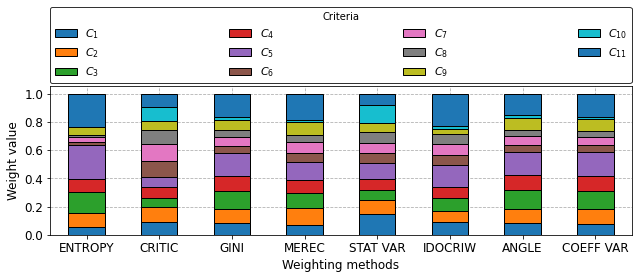

In [15]:
plot_barplot(df_weights, 'Weighting methods', 'Weight value', 'Criteria')

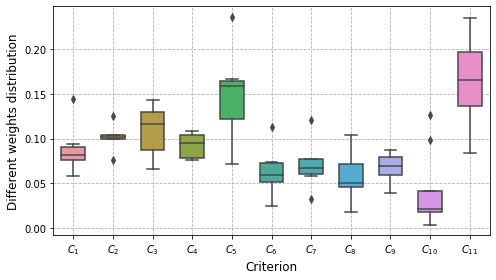

In [16]:
plot_boxplot(df_weights.T)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


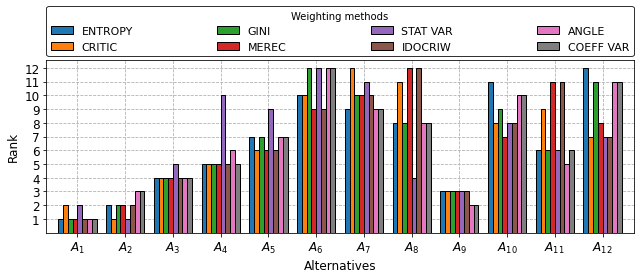

In [17]:
plot_barplot(df_rankings, 'Alternatives', 'Rank', 'Weighting methods')

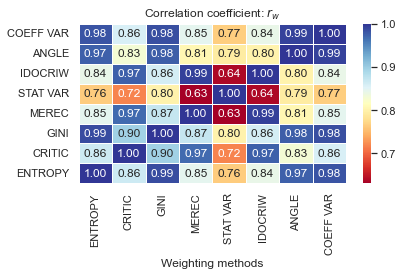

In [18]:
results = copy.deepcopy(df_rankings)
method_types = list(results.columns)
dict_new_heatmap_rw = Create_dictionary()

for el in method_types:
    dict_new_heatmap_rw.add(el, [])

# heatmaps for correlations coefficients
for i, j in [(i, j) for i in method_types[::-1] for j in method_types]:
    dict_new_heatmap_rw[j].append(corrs.weighted_spearman(results[i], results[j]))

df_new_heatmap_rw = pd.DataFrame(dict_new_heatmap_rw, index = method_types[::-1])
df_new_heatmap_rw.columns = method_types

# correlation matrix with rw coefficient
draw_heatmap(df_new_heatmap_rw, r'$r_w$')

## Stochastic Multicriteria Acceptability Analysis Method (SMAA)

In [19]:
cols_ai = [str(el) for el in range(1, matrix.shape[0] + 1)]

In [20]:
# criteria number
n = matrix.shape[1]
# number of SMAA iterations
iterations = 10000

In [21]:
# create the VIKOR_SMAA method object
vikor_smaa = VIKOR_SMAA()
# generate multiple weight vectors in matrix
weight_vectors = vikor_smaa._generate_weights(n, iterations)

In [22]:
# Calculate the rank acceptability index, central weight vector and final ranking
rank_acceptability_index, central_weight_vector, rank_scores = vikor_smaa(matrix, weight_vectors, types)

In [23]:
acc_in_df = pd.DataFrame(rank_acceptability_index, index = list_alt_names, columns = cols_ai)
acc_in_df.to_csv('results_smaa/ai.csv')

### Rank acceptability indexes
This is dataframe with rank acceptability indexes for each alternative in relation to ranks. Rank acceptability index shows the share of different scores placing an alternative in a given rank.

In [24]:
acc_in_df

,1,2,3,4,5,6,7,8,9,10,11,12
$A_{1}$,0.2362,0.2568,0.1835,0.1387,0.0527,0.0515,0.0225,0.0418,0.0127,0.0036,0.0000,0.0000
$A_{2}$,0.2275,0.3477,0.2215,0.1245,0.0426,0.0295,0.0067,0.0000,0.0000,0.0000,0.0000,0.0000
$A_{3}$,0.0003,0.0103,0.0245,0.0766,0.2942,0.1366,0.1508,0.1312,0.1667,0.0088,0.0000,0.0000
$A_{4}$,0.1000,0.0661,0.0732,0.1385,0.1657,0.2421,0.0772,0.0375,0.0309,0.0359,0.0329,0.0000
$A_{5}$,0.0003,0.0106,0.0125,0.0195,0.0732,0.1075,0.2602,0.1469,0.1243,0.2227,0.0223,0.0000
$A_{6}$,0.0000,0.0003,0.0086,0.0437,0.0216,0.0350,0.1309,0.1130,0.1623,0.1659,0.1373,0.1814
$A_{7}$,0.0000,0.0000,0.0008,0.0013,0.0063,0.0342,0.0294,0.0343,0.0875,0.0762,0.0928,0.6372
$A_{8}$,0.0000,0.0018,0.0014,0.0063,0.0650,0.0458,0.0575,0.1444,0.0761,0.1124,0.4505,0.0388
$A_{9}$,0.3883,0.1099,0.2878,0.0365,0.0311,0.0269,0.0204,0.0157,0.0592,0.0242,0.0000,0.0000
$A_{10}$,0.0096,0.0398,0.0651,0.0694,0.0870,0.1581,0.0947,0.0754,0.1500,0.1488,0.0904,0.0117


Rank acceptability indexes displayed in the form of stacked bar chart.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


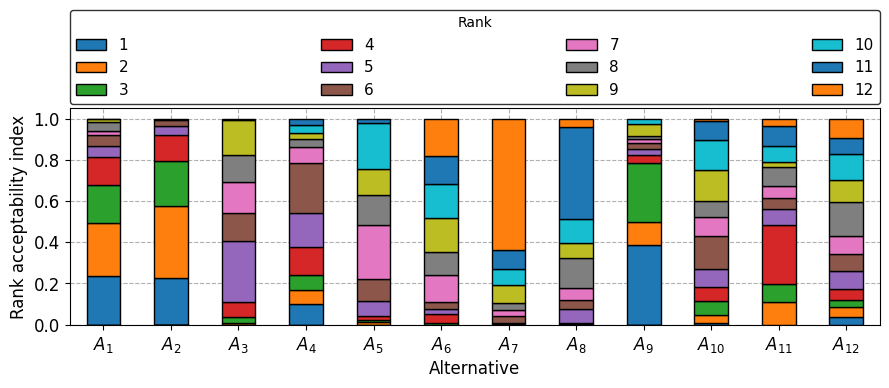

In [25]:
matplotlib.rcdefaults()
plot_barplot(acc_in_df, 'Alternative', 'Rank acceptability index', 'Rank')

Rank acceptability indexes displayed in the form of heatmap

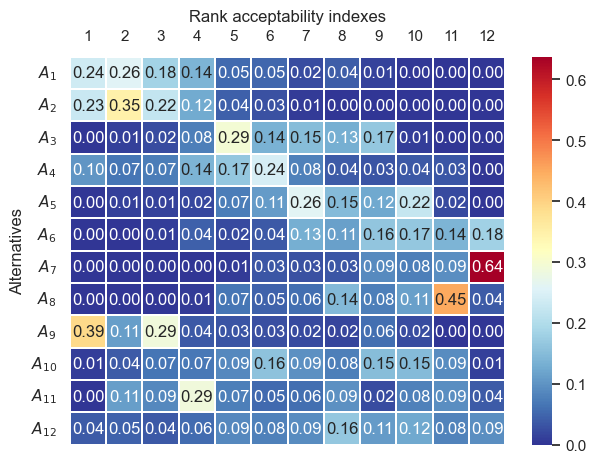

In [26]:
draw_heatmap_smaa(acc_in_df, 'Rank acceptability indexes')

### Central weight vector
The central weight vector describes the preferences of a typical decision-maker, supporting this alternative with the assumed preference model. It allows the decision-maker to see what criteria preferences result in the best evaluation of given alternatives. Rows containing only zeroes mean that a given alternative never becomes a leader.

In [27]:
central_weights_df = pd.DataFrame(central_weight_vector, index = list_alt_names, columns = cols)
central_weights_df.to_csv('results_smaa/cw.csv')

In [28]:
central_weights_df

,$C_{1}$,$C_{2}$,$C_{3}$,$C_{4}$,$C_{5}$,$C_{6}$,$C_{7}$,$C_{8}$,$C_{9}$,$C_{10}$,$C_{11}$
$A_{1}$,0.081767,0.067123,0.168040,0.123759,0.122593,0.075804,0.073561,0.076675,0.058107,0.054456,0.098115
$A_{2}$,0.120370,0.088817,0.074862,0.126533,0.055946,0.080248,0.078061,0.081630,0.070315,0.110424,0.112795
$A_{3}$,0.011378,0.031920,0.221420,0.093060,0.137050,0.038998,0.016924,0.022888,0.034455,0.273964,0.117944
$A_{4}$,0.042460,0.080267,0.066423,0.054914,0.067923,0.088656,0.092394,0.080736,0.086954,0.207156,0.132118
$A_{5}$,0.043732,0.293897,0.031455,0.027025,0.062786,0.005345,0.042495,0.016120,0.046958,0.240973,0.189215
$A_{6}$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
$A_{7}$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
$A_{8}$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
$A_{9}$,0.096682,0.116171,0.065802,0.062445,0.105615,0.101896,0.099716,0.101867,0.133830,0.055877,0.060099
$A_{10}$,0.052157,0.033426,0.037122,0.148589,0.036476,0.085904,0.098032,0.082048,0.071769,0.236257,0.118220


### Rank scores

In [29]:
rank_scores_df = pd.DataFrame(rank_scores, index = list_alt_names, columns = ['Rank'])
rank_scores_df.to_csv('results_smaa/fr.csv')

In [30]:
rank_scores_df

,Rank
$A_{1}$,3
$A_{2}$,1
$A_{3}$,6
$A_{4}$,4
$A_{5}$,9
$A_{6}$,10
$A_{7}$,12
$A_{8}$,11
$A_{9}$,2
$A_{10}$,7
